## Семинар 9: "Генерация текстов"

ФИО: Богатенкова Анастасия Олеговна

In [1]:
import numpy as np
import re
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import sys
from IPython.display import clear_output
import tqdm
import progressbar
from itertools import product
%matplotlib inline

Этот семинар посвящен чат-ботам. Вам предстоит реализовать модель, генерирующую определенные тексты. В качестве текстов можно взять сборник цитат умных людей, предсказаний и т.д. На семинаре мы используем данные https://github.com/alvations/Quotables/blob/master/author-quote.txt

При реализации задания вы можете пользоваться кодом из этого примера: <a href=https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb>Generating Shakespeare with a Character-Level RNN</a>

### Часть 1: подготовка данных

Реализуйте датасет для дальнейшего обучения (будем использовать batch size=1)

In [2]:
lines = [x.split('\t')[1].strip() for x in open('author-quote.txt').readlines()]

In [3]:
lines[:5]

['If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.',
 "Promise me you'll always remember: You're braver than you believe, and stronger than you seem, and smarter than you think.",
 'Did you ever stop to think, and forget to start again?',
 'Organizing is what you do before you do something, so that when you do it, it is not all mixed up.',
 'Weeds are flowers too, once you get to know them.']

Распределение длин цитат (в буквах)

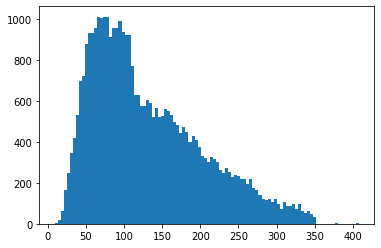

In [4]:
plt.hist(list(map(len, lines)), bins=100);

Распределение длин цитат (в словах)

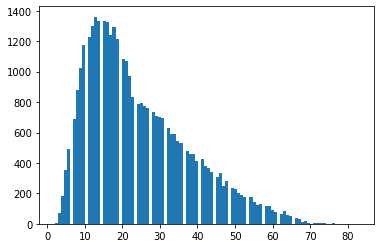

In [5]:
plt.hist(list(map(lambda x: len(x.split()), lines)), bins=100);

In [6]:
line = lines[0]

In [7]:
line

'If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.'

In [8]:
lines = list(filter(lambda x: len(x.split()) <= 50, lines))

In [9]:
np.random.seed(777)
torch.random.manual_seed(777)

In [10]:
class Vocabulary:
    def __init__(self, sentences):
        all_characters = set()
        for line in sentences:
            all_characters |= set(line)
        all_characters = list(sorted(all_characters))+['<eos>', '<go>']
        self.char_to_id = {x[1]:x[0] for x in enumerate(all_characters)}
        self.id_to_char = {x[0]:x[1] for x in enumerate(all_characters)}
        self.size = len(all_characters)

    def encode(self, line):
        return [self.char_to_id[x] for x in line]
    
    def decode(self, tokens):
        return ''.join([self.id_to_char[x] for x in tokens])

In [11]:
vocab = Vocabulary(lines)

In [12]:
assert vocab.decode(vocab.encode(lines[0])) == lines[0]

In [13]:
class Quotes(Dataset):
    def __init__(self, sentences, vocab):
        # Construct vocabulary + EOS & GO tokens
        self.sentences = sentences
        self.vocab = vocab
        self.go = self.vocab.char_to_id['<go>']
        self.eos = self.vocab.char_to_id['<eos>']
        
    def __len__(self):
        return len(self.sentences)
        
    def __getitem__(self, idx):
        tokens = self.vocab.encode(self.sentences[idx])
        _input = np.array([self.go]+tokens)
        _output = np.array(tokens+[self.eos])
        return _input, _output

In [14]:
def compose_batch(batch):
    order = np.argsort([-len(x[0]) for x in batch])
    lengths = np.array([len(x[0]) for x in batch])
    go = torch.zeros(len(batch), lengths[order[0]]).long()
    eos = torch.zeros(len(batch), lengths[order[0]]).long()
    mask = torch.zeros(len(batch), lengths[order[0]]).long()
    for i in range(len(batch)):
        current_go, current_eos = batch[i]
        go[i, :len(current_go)] = torch.tensor(current_go)
        eos[i, :len(current_eos)] = torch.tensor(current_eos)
        mask[i, :len(current_go)] = 1
    mask = mask[order]
    go = go[order]
    eos = eos[order]
    lengths = lengths[order]
    return go, eos, mask, lengths

In [15]:
dataset = Quotes(lines, vocab)

In [16]:
dataloader = DataLoader(dataset, shuffle=True, batch_size=64, collate_fn=compose_batch)

### Часть 2: определение модели

In [17]:
class Oracle(nn.Module):
    def __init__(self, vocabulary_size, embedding_size=128, hidden_size=256, layers=2):
        super(Oracle, self).__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.generator = nn.GRU(embedding_size, hidden_size, layers, batch_first=False)
        self.classifier = nn.Linear(hidden_size, vocabulary_size)

    def forward(self, _input, lengths):
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(embedding, lengths)
        output, _ = self.generator(embedding)
        output = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output[0])
        return classes

    def generate(self, vocab, max_len=100):
        h = Variable(torch.zeros(self.layers, 1, self.hidden_size))
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and len(line) < max_len:
            token = torch.Tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = Variable(token, volatile=True)
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token
        return line

In [18]:
oracle = Oracle(vocab.size, embedding_size=32, hidden_size=64, layers=2)

### Часть 3: обучение модели

In [19]:
optimizer = torch.optim.RMSprop(oracle.parameters(), lr=0.001, weight_decay=1e-5)

In [20]:
criterion = nn.CrossEntropyLoss(reduction='none')

In [21]:
losses = []

In [22]:
def moving_average(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

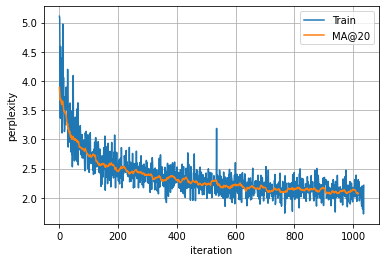

100%|██████████| 536/536 [25:09<00:00,  2.82s/it]


In [23]:
for epoch in range(2):
    bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(tqdm.tqdm(dataloader, total=len(dataloader))):
        oracle.zero_grad()
        prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).mean()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle.parameters()]
        optimizer.step()
        losses.append(np.exp(loss.item()))
        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses, label='Train')
            plt.plot(moving_average(losses), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()

### Часть 4: оценивание модели

<i> Приведите примеры сгенерированных предложений </i>

In [24]:
oracle.generate(vocab)

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


'I are expolication of theiries.<eos>'

## HW 1 (3 балла)
1. Обучить сеть с LSTM вместо GRU
2. Сделать разбиение train-test и нарисровать графики зависимости перплексии от числа эпох
3. Подобрать гиперпараметры, добиться лучшей перплексии чем с параметрами по умолчанию

1. LSTM

In [25]:
class LSTMOracle(nn.Module):
    def __init__(self, vocabulary_size, embedding_size=128, hidden_size=256, layers=2):
        super(LSTMOracle, self).__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.generator = nn.LSTM(embedding_size, hidden_size, layers, batch_first=False)
        self.classifier = nn.Linear(hidden_size, vocabulary_size)

    def forward(self, _input, lengths):
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(embedding, lengths)
        output, _ = self.generator(embedding)
        output = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output[0])
        return classes

    def generate(self, vocab, max_len=100):
        h = (Variable(torch.zeros(self.layers, 1, self.hidden_size)),
             Variable(torch.zeros(self.layers, 1, self.hidden_size)))
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and len(line) < max_len:
            token = torch.Tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = Variable(token, volatile=True)
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token
        return line

In [26]:
lstm_oracle = LSTMOracle(vocab.size, embedding_size=32, hidden_size=64, layers=2)
optimizer = torch.optim.Adam(lstm_oracle.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss(reduction='none')
train_losses = []
test_losses = []

2. Train/test

In [27]:
train_size = int(len(lines) * 0.67)
test_size = len(lines) - train_size

train_dataset = Quotes(lines[:train_size], vocab)
test_dataset = Quotes(lines[train_size:], vocab)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64, collate_fn=compose_batch)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=64, collate_fn=compose_batch)

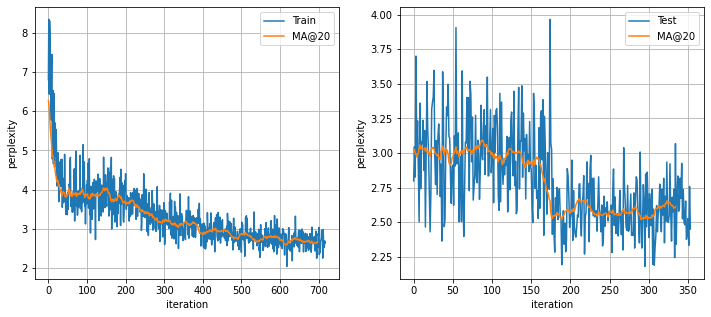

In [28]:
for epoch in range(2):
    bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(tqdm.tqdm(train_dataloader, 
                                                          total=len(train_dataloader))):
        lstm_oracle.zero_grad()
        prediction = lstm_oracle(go, length).transpose(0, 1).transpose(1, 2)
        train_loss = (criterion(prediction, eos) * mask.float()).mean()
        train_loss.backward()
        [x.grad.clamp_(-1, 1) for x in lstm_oracle.parameters()]
        optimizer.step()
        train_losses.append(np.exp(train_loss.item()))
    for i, (go, eos, mask, length) in enumerate(tqdm.tqdm(test_dataloader, 
                                                          total=len(test_dataloader))):
        prediction = lstm_oracle(go, length).transpose(0, 1).transpose(1, 2)
        test_loss = (criterion(prediction, eos) * mask.float()).mean()
        test_losses.append(np.exp(test_loss.item()))
        
    clear_output(True)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(moving_average(train_losses), label='MA@20')
    plt.xlabel('iteration')
    plt.ylabel('perplexity')
    plt.legend()
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.plot(test_losses, label='Test')
    plt.plot(moving_average(test_losses), label='MA@20')
    plt.xlabel('iteration')
    plt.ylabel('perplexity')
    plt.legend()
    plt.grid()
    plt.show()

3. Hyperparameters

In [29]:
params = product(
    [64, 128, 256], # embedding_size
    [128, 256, 512], # hidden_size
)

In [30]:
min_loss = 100
res_model = None
res_losses = None

In [34]:
for embedding_size, hidden_size in tqdm.tqdm(list(params)):
    lstm_oracle = LSTMOracle(vocab.size, embedding_size=embedding_size,
                             hidden_size=hidden_size, layers=2)
    optimizer = torch.optim.Adam(lstm_oracle.parameters(), lr=0.001, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss(reduction='none')
    losses = []
    for epoch in range(2):
        bar = progressbar.ProgressBar()
        for i, (go, eos, mask, length) in enumerate(tqdm.tqdm(dataloader, total=len(dataloader))):
            lstm_oracle.zero_grad()
            prediction = lstm_oracle(go, length).transpose(0, 1).transpose(1, 2)
            loss = (criterion(prediction, eos) * mask.float()).mean()
            loss.backward()
            [x.grad.clamp_(-1, 1) for x in lstm_oracle.parameters()]
            optimizer.step()
            losses.append(np.exp(loss.item()))
    if loss < min_loss:
        min_loss = loss
        res_losses = losses
        res_model = lstm_oracle

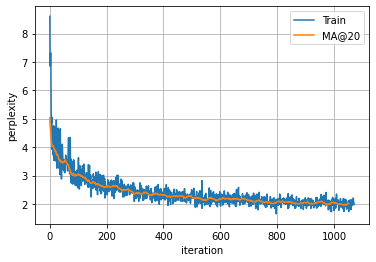

In [32]:
plt.plot(res_losses, label='Train')
plt.plot(moving_average(res_losses), label='MA@20')
plt.xlabel('iteration')
plt.ylabel('perplexity')
plt.legend()
plt.grid()
plt.show()

In [33]:
res_model, min_loss

(LSTMOracle(
   (embedding): Embedding(84, 64)
   (generator): LSTM(64, 256, num_layers=2)
   (classifier): Linear(in_features=256, out_features=84, bias=True)
 ),
 tensor(0.6820, grad_fn=<MeanBackward0>))

In [35]:
for i in range(10):
    print(lstm_oracle.generate(vocab))

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Not.<eos>
I've havoust of how seaturite. It the rangs esssorg enore aratifus Fanst he trove thading stuZt Fera
A reans deal lee and adion wating are mrable poetnections of a alfak to but domazent's ones in I mog
I's suulking the.<eos>
When ffeginent the bealy lyone aoth you falls. Lut shere the anald ecy af Garge my hame. naretis and
That bebut to ned me lot is in bucter diveryrald.<eos>
There mate. I'd nom am has of of that that tree fornce - very, piplive, but beer bent decar tire lig
I was a muver Doing hand a grearmo and feal Nhaned the grateato reago comlisife who tast it tery apa
I we worrores. Thote that, I dems0uinod, wat.<eos>
I poent ters. I'w're there athing affeamtnoniance lepy and in dare of leal to more, guscliso frog fi


#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: